## Imports

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn. metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

### Read data into DFs

In [110]:
# 1. Column names (15 features + label)
headers = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'pred'   # label (<=50K / >50K)
]

# 2. Read raw data
original_train_df = pd.read_csv(
    "census-income.data.csv",
    header=None,
    names=headers,
    index_col=False
)

original_test_df = pd.read_csv(
    "census-income.test.csv",
    header=None,
    names=headers,
    index_col=False
)

# Work on copies
train_df = original_train_df.copy()
test_df = original_test_df.copy()

In [111]:
#strip whitespace

def data_to_str(df):
    """
    Strip leading/trailing spaces from all string (object) columns.
    """
    str_cols = df.select_dtypes(include=['object']).columns
    for col in str_cols:
        df[col] = df[col].str.strip()
    return df

# Apply to both train and test
train_df = data_to_str(train_df)
test_df = data_to_str(test_df)

In [112]:
# Remove trailing period if present
test_df['pred'] = test_df['pred'].str.rstrip('.')

In [113]:
# Convert "?" to missing values (NaN) in both dataframes
train_df.replace("?", np.nan, inplace=True)
test_df.replace("?", np.nan, inplace=True)

# Sanity check: how many missing values per column?
train_df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
pred                 0
dtype: int64

In [114]:
# Before dropping
print("Train shape before dropping NaN:", train_df.shape)
print("Test shape before dropping NaN:", test_df.shape)

Train shape before dropping NaN: (32561, 15)
Test shape before dropping NaN: (16281, 15)


In [117]:
#convert numeric columns to integer types

def data_to_int32(df):
    """
    Convert known numeric columns to int32 (or Int64 if you want to allow NaN).
    """
    int_cols = [
        'age',
        'fnlwgt',
        'education-num',
        'capital-gain',
        'capital-loss',
        'hours-per-week'
    ]
    for col in int_cols:
        df[col] = df[col].astype('int32')
    return df

train_df = data_to_int32(train_df)
test_df = data_to_int32(test_df)

train_df.dtypes

age                int32
workclass         object
fnlwgt             int32
education         object
education-num      int32
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int32
capital-loss       int32
hours-per-week     int32
native-country    object
pred              object
dtype: object

In [118]:
#removing duplicate rows

print("Train duplicates:", train_df.duplicated().sum())
print("Test duplicates:", test_df.duplicated().sum())

train_df = train_df.drop_duplicates()
#test_df = test_df.drop_duplicates()

print("Train shape after dedup:", train_df.shape)
#print("Test shape after dedup:", test_df.shape)

Train duplicates: 24
Test duplicates: 5
Train shape after dedup: (32537, 15)


In [119]:
#removing duplicate rows

print("Train duplicates:", train_df.duplicated().sum())
print("Test duplicates:", test_df.duplicated().sum())

train_df = train_df.drop_duplicates()
#test_df = test_df.drop_duplicates()

print("Train shape after dedup:", train_df.shape)
#print("Test shape after dedup:", test_df.shape)

Train duplicates: 0
Test duplicates: 5
Train shape after dedup: (32537, 15)


## Recategorize the Categorical features into more meaningful groups

In [120]:
workclass_mapping = {
    'State-gov':'Government',
    'Local-gov':'Government',
    'Federal-gov':'Government',
    'Self-emp-inc':'Entrepreneur',
    'Self-emp-not-inc':'Entrepreneur',
    'Without-pay':'Unemployed',
    'Never-worked':'Unemployed',
    'Private':'Private'
}

# Apply mapping and insert into dataframe
train_df.insert(2,'workclass-cat',train_df['workclass'].map(workclass_mapping))
test_df.insert(2,'workclass-cat',train_df['workclass'].map(workclass_mapping))

edu_mapping = {
    'Preschool':'HS-dropout',
    '1st-4th':'HS-dropout',
    '5th-6th':'HS-dropout',
    '7th-8th':'HS-dropout',
    '9th':'HS-dropout',
    '10th':'HS-dropout',
    '11th':'HS-dropout',
    '12th':'HS-dropout',
    'HS-grad':'HS-grad',
    'Some-college':'Some-college',
    'Assoc-acdm':'Some-college',
    'Assoc-voc':'Some-college',
    'Bachelors':'Bachelors',
    'Masters':'Advanced-degree',
    'Prof-school':'Advanced-degree',
    'Doctorate':'Advanced-degree'
}

train_df.insert(4,"education-cat",train_df['education'].map(edu_mapping))
test_df.insert(4,"education-cat",train_df['education'].map(edu_mapping))

marital_mapping = {
    'Never-married':'Single/Unmarried',
    'Divorced':'Single/Unmarried',
    'Separated':'Single/Unmarried',
    'Widowed':'Single/Unmarried',
    'Married-spouse-absent':'Single/Unmarried',
    'Married-civ-spouse':'Married',
    'Married-AF-spouse':'Married'
}

train_df.insert(7,'marital-cat',train_df['marital-status'].map(marital_mapping))
test_df.insert(7,'marital-cat',train_df['marital-status'].map(marital_mapping))
occupation_mapping = {
    'Exec-managerial':'White-collar',
    'Prof-specialty':'White-collar',
    'Tech-support':'White-collar',
    
    'Other-service':'Service',
    'Sales':'Service',
    'Adm-clerical':'Service',
    'Protective-serv':'Service',
    
    'Craft-repair':'Blue-collar',
    'Transport-moving':'Blue-collar',
    'Machine-op-inspct':'Blue-collar',

    'Armed-Forces':'Military',

    'Priv-house-serv':'Manual',
    'Farming-fishing':'Manual',
    'Handlers-cleaners':'Manual'
}

train_df.insert(10,'occupation-cat',train_df['occupation'].map(occupation_mapping))
test_df.insert(10,'occupation-cat',train_df['occupation'].map(occupation_mapping))
s = train_df['native-country']

native_imm_cat = (
    s.map({'United-States': 'Native'})         # US → Native, others → NaN
     .fillna('Immigrant')                     # non-US, non-missing → Immigrant
     .where(s.notna(), pd.NA)                 # where original was missing, keep NA
)

native_imm_cat.replace({pd.NA:np.nan}, inplace = True)

train_df.insert(18, 'native_imm_cat', native_imm_cat)
test_df.insert(18, 'native_imm_cat', native_imm_cat)

# drop all adjusted categorical features in favor of their derived categories
train_df.drop(['workclass','fnlwgt','education','education-num','marital-status','occupation','native-country'], axis = 1, inplace = True)
test_df.drop(['workclass','fnlwgt','education','education-num','marital-status','occupation','native-country'], axis = 1, inplace = True)



In [121]:
#X_train= train_df.drop ('pred', axis=1)
#Y_train= train_df['pred']

#X_test = test_df.drop('pred', axis=1)
#Y_test = test_df['pred']

#cat_cols = X_train.select_dtypes(include='object').columns.tolist()
#num_cols = X_train.select_dtypes(exclude='object').columns.tolist()
#print (cat_cols)
#print (num_cols)

## Missing Values

In [122]:
train_df.isna().sum()

age                  0
workclass-cat     1836
education-cat        0
marital-cat          0
occupation-cat    1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native_imm_cat     582
pred                 0
dtype: int64

In [123]:
test_df.isna().sum()

age                 0
workclass-cat     922
education-cat       6
marital-cat         6
occupation-cat    925
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native_imm_cat    305
pred                0
dtype: int64

In [124]:
#Columns that have missing values
columns = {'workclass-cat', 'occupation-cat', 'native_imm_cat'}
columns_test = {'workclass-cat', 'occupation-cat', 'native_imm_cat','education-cat','marital-cat'}

In [125]:
#Print only the columns that contain NA values
for col in columns:
    if train_df[col].isna().any():
        print(f"\n{col}")
        print(train_df[col].unique())


occupation-cat
['Service' 'White-collar' 'Manual' 'Blue-collar' nan 'Military']

native_imm_cat
['Native' 'Immigrant' nan]

workclass-cat
['Government' 'Entrepreneur' 'Private' nan 'Unemployed']


In [127]:
##### TRAIN
#Imputation: mode - 2
df_mode = train_df.copy()

for col in columns:
    df_mode[col] = df_mode[col].fillna(df_mode[col].mode()[0])

df_mode.head()



#### TEST
#Imputation: mode - 2
test_df_mode = test_df.copy()

for col in columns_test:
    test_df_mode[col] = test_df_mode[col].fillna(test_df_mode[col].mode()[0])

test_df_mode.isna().sum()

age               0
workclass-cat     0
education-cat     0
marital-cat       0
occupation-cat    0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native_imm_cat    0
pred              0
dtype: int64

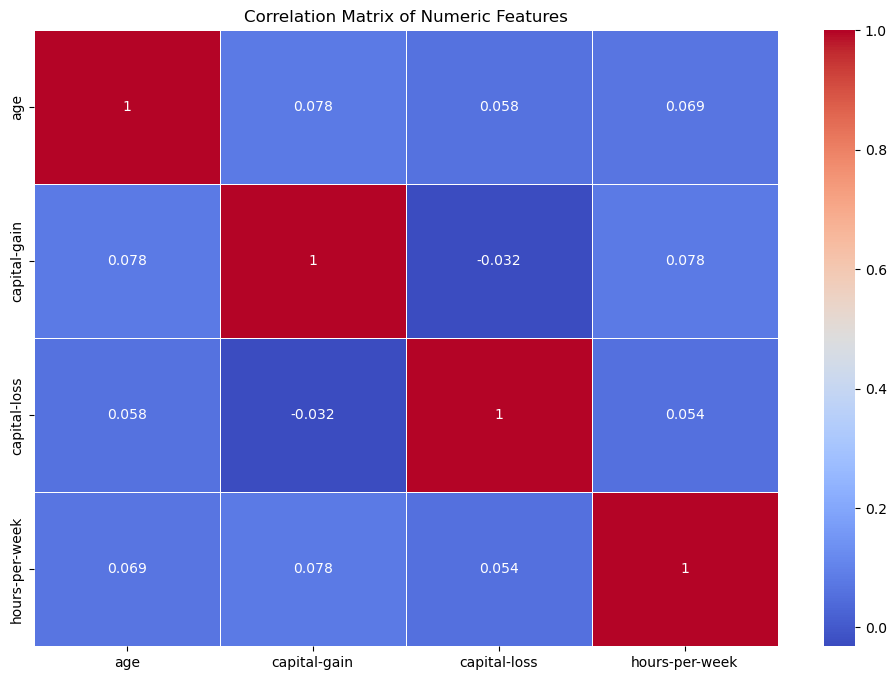

In [99]:
#OHE for numerical features only

# Select numeric columns only
#numeric_df = train_df.select_dtypes(include=['int32', 'int64', 'float64'])
numeric_df = df_mode.select_dtypes(include=['int32', 'int64', 'float64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

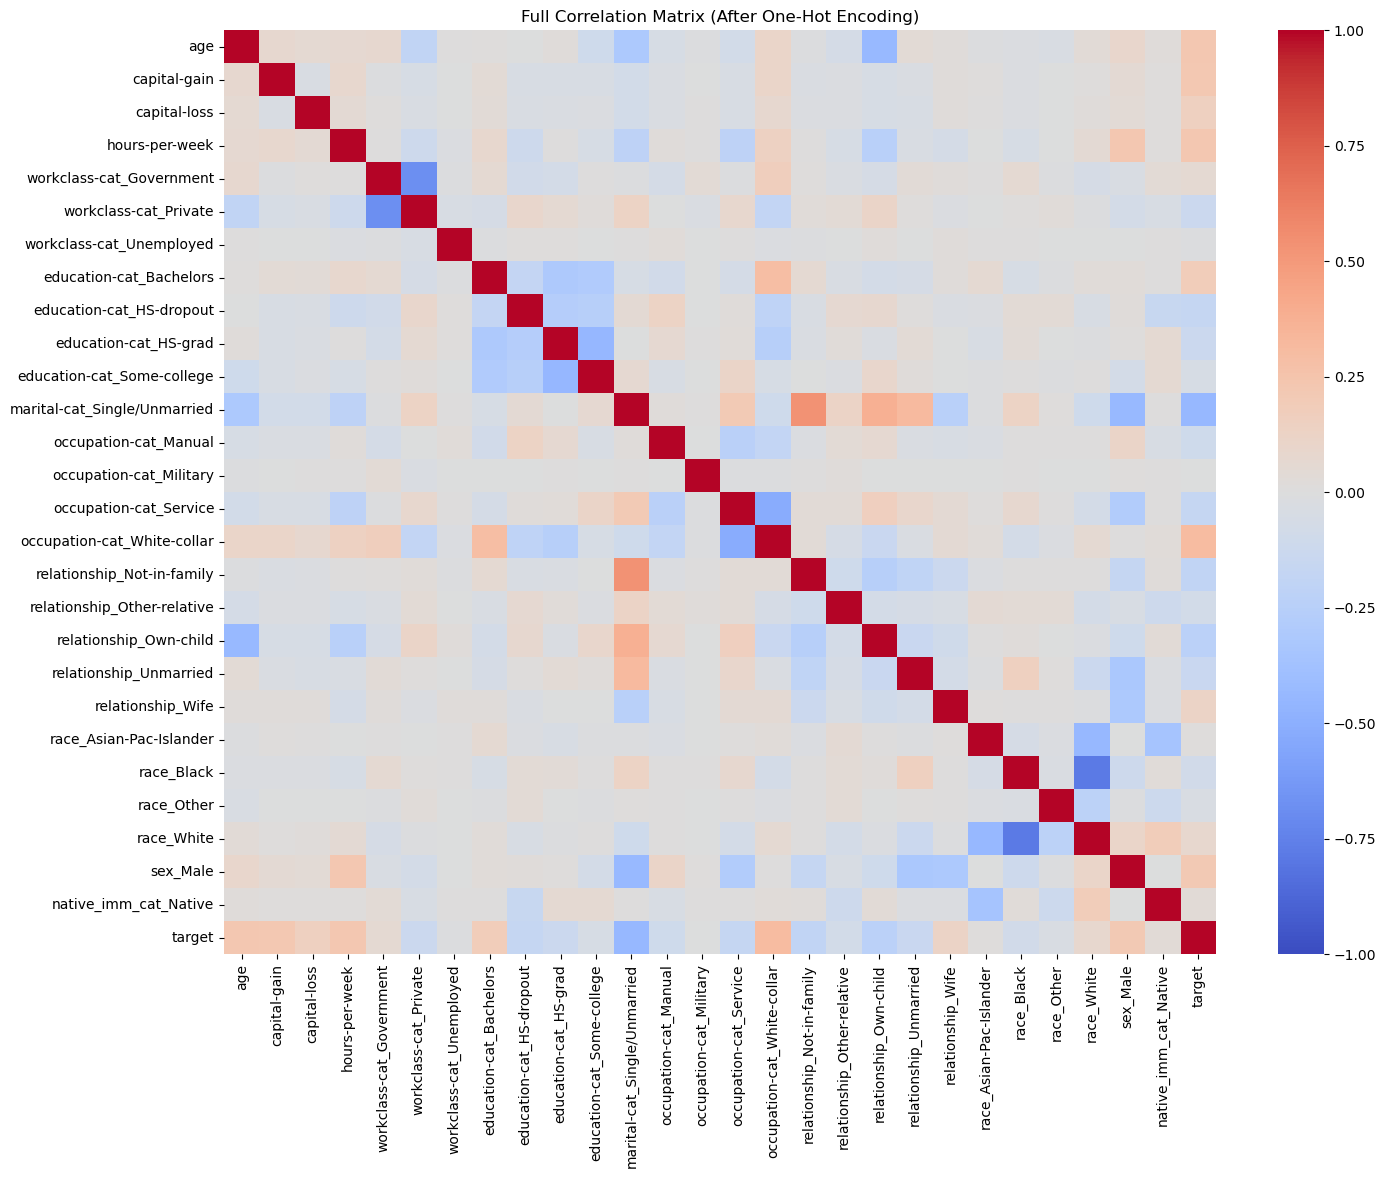

In [100]:
#OHE for correlation matrix

# One-hot encode categorical features
#encoded_df = pd.get_dummies(train_df.drop(columns=['pred']), drop_first=True)
encoded_df = pd.get_dummies(df_mode.drop(columns=['pred']), drop_first=True)

# Add encoded label for correlation study
#encoded_df['target'] = train_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)
encoded_df['target'] = df_mode['pred'].apply(lambda x: 1 if x == '>50K' else 0)

corr = encoded_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Full Correlation Matrix (After One-Hot Encoding)")
plt.show()

In [101]:
# Convert pred to binary
#binary_corr_df = train_df.copy()
binary_corr_df = df_mode.copy()
binary_corr_df['target'] = binary_corr_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)

# One-hot encode ALL features except target
encoded = pd.get_dummies(binary_corr_df.drop(columns=['pred']), drop_first=True)

# Compute correlation with target only
corr_target = encoded.corr()['target'].sort_values(ascending=False)

corr_target

target                          1.000000
occupation-cat_White-collar     0.305514
age                             0.234037
hours-per-week                  0.229658
capital-gain                    0.223336
sex_Male                        0.215969
education-cat_Bachelors         0.180535
capital-loss                    0.150501
relationship_Wife               0.123230
race_White                      0.085235
workclass-cat_Government        0.061812
native_imm_cat_Native           0.038702
race_Asian-Pac-Islander         0.010600
occupation-cat_Military        -0.005049
workclass-cat_Unemployed       -0.014317
race_Other                     -0.031861
education-cat_Some-college     -0.052184
relationship_Other-relative    -0.083782
race_Black                     -0.089107
occupation-cat_Manual          -0.108385
workclass-cat_Private          -0.125504
education-cat_HS-grad          -0.131343
relationship_Unmarried         -0.142948
education-cat_HS-dropout       -0.166267
occupation-cat_S

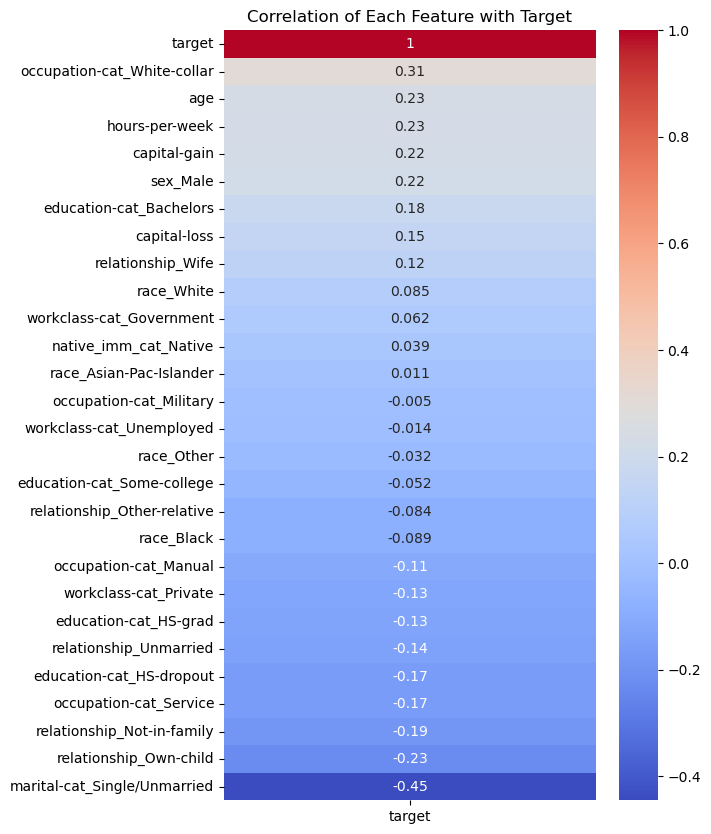

In [102]:
plt.figure(figsize=(6,10))
sns.heatmap(corr_target.to_frame(), annot=True, cmap='coolwarm')
plt.title("Correlation of Each Feature with Target")
plt.show()

In [103]:
# Remove native-country
encoded_filtered = encoded.drop(columns=[col for col in encoded.columns 
                                         if col.startswith("native-country_")])

# Remove numeric columns
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                'capital-loss', 'hours-per-week', 'target']  
encoded_filtered = encoded_filtered.drop(columns=[col for col in numeric_cols 
                                                  if col in encoded_filtered.columns])

# Compute correlation with target only (SORTED DESCENDING)
corr_target_only = encoded_filtered.join(binary_corr_df['target']) \
                                   .corr()['target'] \
                                   .sort_values(ascending=False)


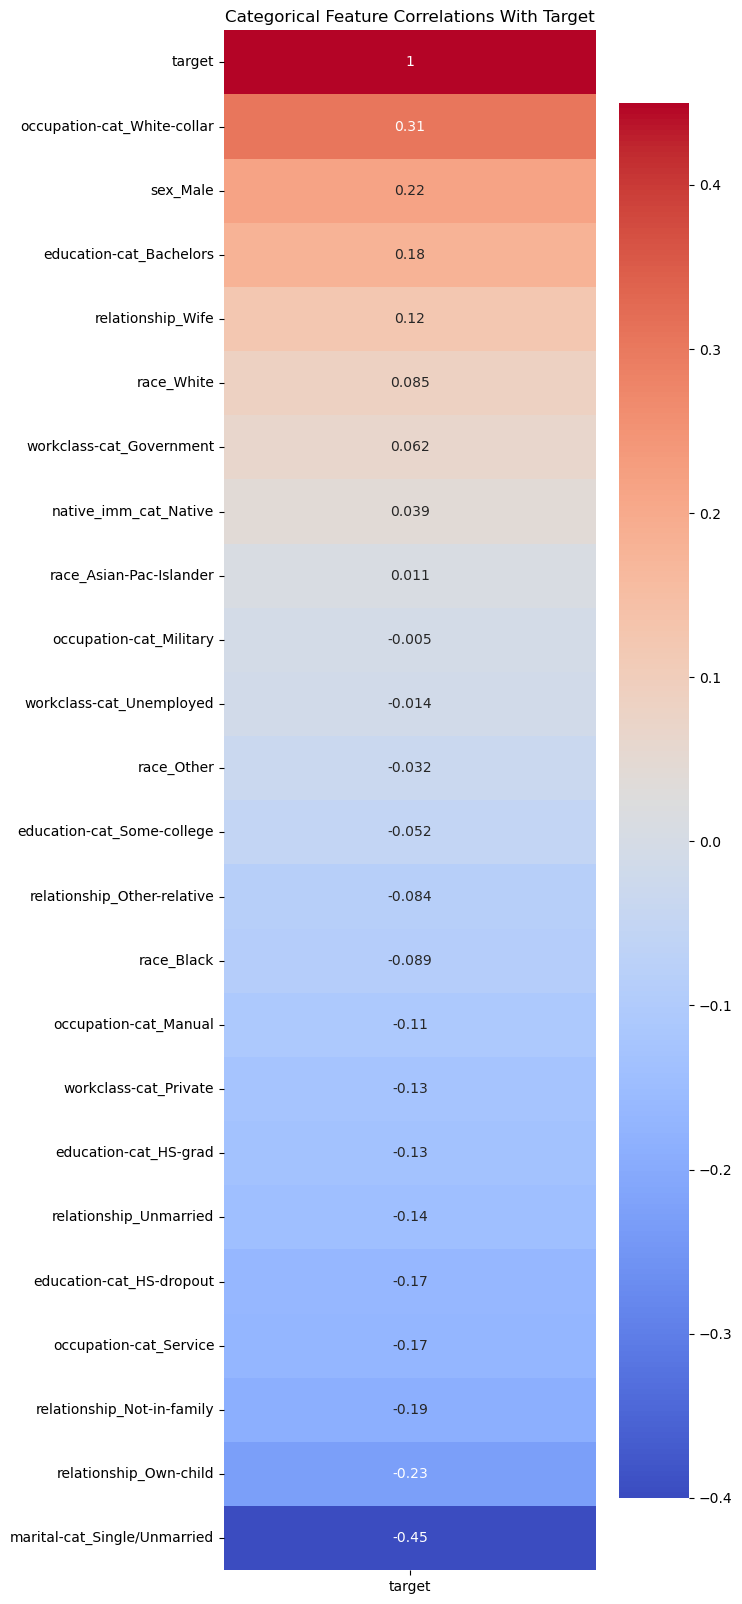

In [104]:
plt.figure(figsize=(6, 20))
sns.heatmap(corr_target_only.to_frame(),
            annot=True,
            cmap='coolwarm',
            vmin=-0.4,
            vmax=0.45)
plt.title("Categorical Feature Correlations With Target")
plt.show()

In [68]:
# Full correlation matrix among remaining categorical columns
cat_corr_matrix = encoded_filtered.corr()

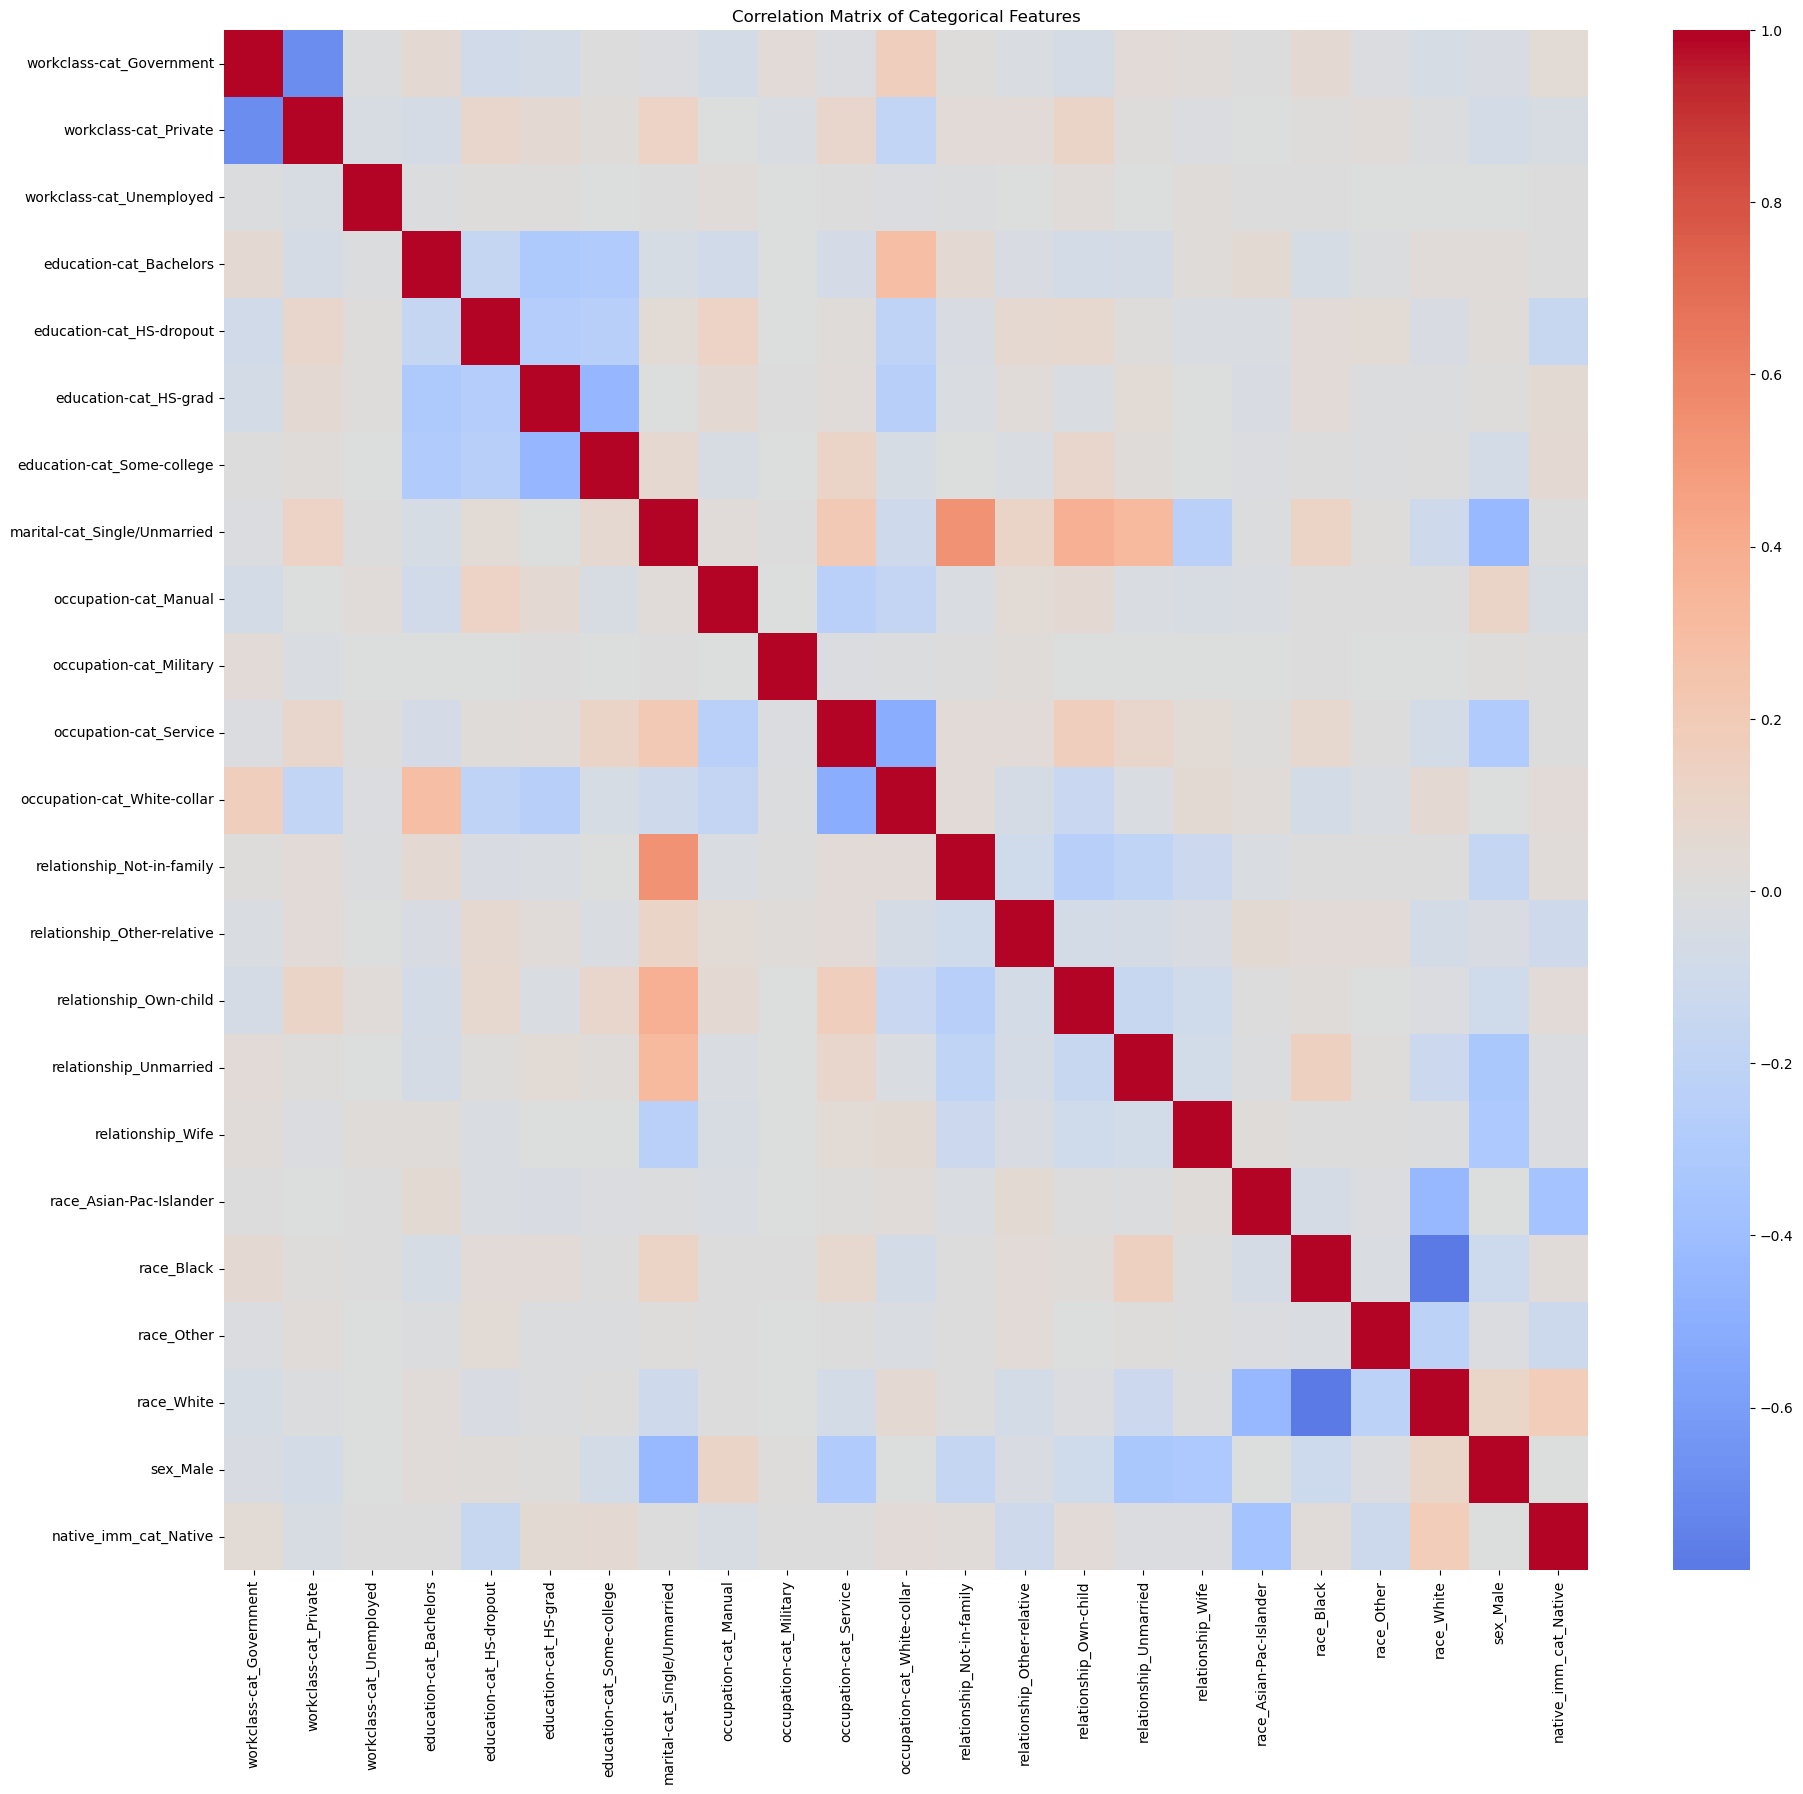

In [69]:
plt.figure(figsize=(22, 20))
sns.heatmap(cat_corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Categorical Features")
plt.show()

## Normalization --- Jieun's Part

capital-gain and capital-loss variables are extremely right-skewed with heavy zeros and a few large outliers. Standard normalization (like Min–Max or Z-score) will not work well.

In [70]:
#Log transformation (best for heavy right-skew)
#log_train_df = train_df.copy()
log_train_df = df_mode.copy()

log_train_df['capital_gain_log'] = np.log1p(log_train_df['capital-gain'])
log_train_df['capital_loss_log'] = np.log1p(log_train_df['capital-loss'])

#log1p(x) handles zeros safely.
#Compresses extreme values.
#Spreads out dense low-value regions.

In [129]:
##for the testing data

#log_train_df = train_df.copy()
log_test_df = test_df_mode.copy()

log_test_df['capital_gain_log'] = np.log1p(log_test_df['capital-gain'])
log_test_df['capital_loss_log'] = np.log1p(log_test_df['capital-loss'])


log_test_df
print(log_test_df['capital_gain_log'].min())
print(log_test_df['capital_gain_log'].max())
print(log_train_df['capital_gain_log'].min())
print(log_train_df['capital_gain_log'].max())

0.0
11.512925464970229
0.0
11.512925464970229


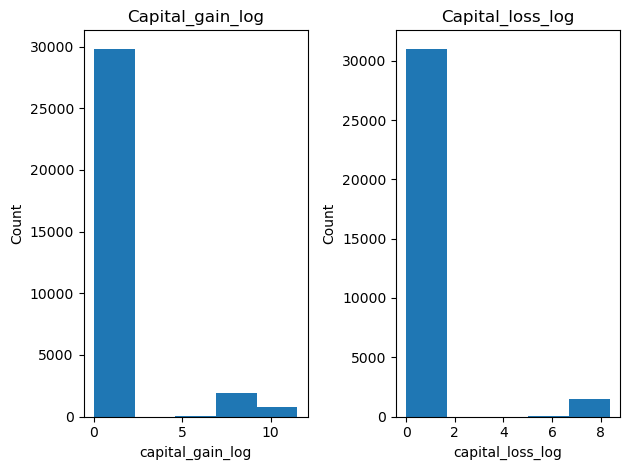

In [130]:
#capital gain
plt.subplot(1, 2, 1)
plt.hist(log_train_df['capital_gain_log'], bins=5)
plt.title("Capital_gain_log")
plt.xlabel("capital_gain_log")
plt.ylabel("Count")

#capital loss
plt.subplot(1, 2, 2)
plt.hist(log_train_df['capital_loss_log'], bins=5)
plt.title("Capital_loss_log")
plt.xlabel("capital_loss_log")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [131]:
log_train_df

,age,workclass-cat,education-cat,marital-cat,occupation-cat,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native_imm_cat,pred,capital_gain_log,capital_loss_log
0,39,Government,Bachelors,Single/Unmarried,Service,Not-in-family,White,Male,2174,0,40,Native,<=50K,7.684784,0.0
1,50,Entrepreneur,Bachelors,Married,White-collar,Husband,White,Male,0,0,13,Native,<=50K,0.000000,0.0
2,38,Private,HS-grad,Single/Unmarried,Manual,Not-in-family,White,Male,0,0,40,Native,<=50K,0.000000,0.0
3,53,Private,HS-dropout,Married,Manual,Husband,Black,Male,0,0,40,Native,<=50K,0.000000,0.0
4,28,Private,Bachelors,Married,White-collar,Wife,Black,Female,0,0,40,Immigrant,<=50K,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Some-college,Married,White-collar,Wife,White,Female,0,0,38,Native,<=50K,0.000000,0.0
32557,40,Private,HS-grad,Married,Blue-collar,Husband,White,Male,0,0,40,Native,>50K,0.000000,0.0
32558,58,Private,HS-grad,Single/Unmarried,Service,Unmarried,White,Female,0,0,40,Native,<=50K,0.000000,0.0
32559,22,Private,HS-grad,Single/Unmarried,Service,Own-child,White,Male,0,0,20,Native,<=50K,0.000000,0.0


In [132]:
X_train= log_train_df.drop (['pred', 'capital-gain','capital-loss'],axis=1)
Y_train= log_train_df['pred']

X_test = log_test_df.drop(['pred', 'capital-gain','capital-loss'], axis=1)
Y_test = log_test_df['pred']
#X_test.isna().sum()

age                 0
workclass-cat       0
education-cat       0
marital-cat         0
occupation-cat      0
relationship        0
race                0
sex                 0
hours-per-week      0
native_imm_cat      0
capital_gain_log    0
capital_loss_log    0
dtype: int64

In [133]:

cat_cols = X_train.select_dtypes(include="object").columns.tolist()
print(X_train.columns.tolist())
print(X_test.columns.tolist())

['age', 'workclass-cat', 'education-cat', 'marital-cat', 'occupation-cat', 'relationship', 'race', 'sex', 'hours-per-week', 'native_imm_cat', 'capital_gain_log', 'capital_loss_log']
['age', 'workclass-cat', 'education-cat', 'marital-cat', 'occupation-cat', 'relationship', 'race', 'sex', 'hours-per-week', 'native_imm_cat', 'capital_gain_log', 'capital_loss_log']


In [135]:
from imblearn.pipeline import Pipeline
imbalances = {
    "none" : "passthrough",
    "under" : RandomUnderSampler(random_state=42),
    "over" : RandomOverSampler(random_state=42)
}
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder="passthrough")

models = {
    "Decision Tree" : DecisionTreeClassifier(random_state=42),
    "Random Forest Classifier" : RandomForestClassifier(random_state=42),
    "Logistic Regression" : LogisticRegression(max_iter=5000,solver="lbfgs"),
    "Bagged Decision Tree": BalancedBaggingClassifier(
        estimator = DecisionTreeClassifier(random_state=42), ## can make more for each 
        n_estimators= 50, 
        sampling_strategy='auto', 
        replacement = False, 
        random_state=42,
        n_jobs=1
    ),
    "Bagged Random Forest": BalancedBaggingClassifier(
        estimator = RandomForestClassifier(random_state=42), ## can make more for each 
        n_estimators= 50, 
        sampling_strategy='auto', 
        replacement = False, 
        random_state=42,
        n_jobs=1
    )
}

for imbalance_methods, method in imbalances.items():
    for model_name, clf in models.items():
        if (model_name in ["Bagged Decision Tree", "Bagged Random Forest"]) and imbalance_methods != "none":
            continue
        print (f"\nImbalance Method: {imbalance_methods} \nModel: {model_name} ")

        if model_name == "Bagged Decision Tree":
                   pipe = Pipeline(steps=[
                       ("encode", preprocess),
                       ("model", clf)
                   ])
        elif model_name == "Bagged Random Forest":
                   pipe = Pipeline(steps=[
                       ("encode", preprocess),
                       ("model", clf)
                   ])
        else: 
                   pipe = Pipeline (steps=[
                       ("encode", preprocess),
                       ("imbalances", method),
                       ("model", clf)
                   ])
        pipe.fit(X_train, Y_train)
        y_pred = pipe.predict(X_test)

        print ("test label distribution:", np.unique(Y_test, return_counts=True))
        print ("predicted label distribution:", np.unique (y_pred, return_counts=True))
        print (classification_report(Y_test, y_pred))
        
        
        
            


Imbalance Method: none 
Model: Decision Tree 
test label distribution: (array(['<=50K', '>50K'], dtype=object), array([12435,  3846]))
predicted label distribution: (array(['<=50K', '>50K'], dtype=object), array([13041,  3240]))
              precision    recall  f1-score   support

       <=50K       0.82      0.86      0.84     12435
        >50K       0.45      0.38      0.41      3846

    accuracy                           0.74     16281
   macro avg       0.63      0.62      0.63     16281
weighted avg       0.73      0.74      0.74     16281


Imbalance Method: none 
Model: Random Forest Classifier 
test label distribution: (array(['<=50K', '>50K'], dtype=object), array([12435,  3846]))
predicted label distribution: (array(['<=50K', '>50K'], dtype=object), array([13764,  2517]))
              precision    recall  f1-score   support

       <=50K       0.82      0.91      0.87     12435
        >50K       0.57      0.37      0.45      3846

    accuracy                          